In [67]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [68]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../../data/benchmark-cluster/SpinodalDecompositionMPI/"):
    for name in dirs:
        directories.append(os.path.join(root, name))

count = 0
for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        tuning_algorithm = directory.split("/")[-1]
        rank = directory.split("/")[-2]
        thread = directory.split("/")[-3]
        scenario = directory.split("/")[-4]

        with open(os.path.join(directory, file)) as f:
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not rank in data[scenario][thread]:
            data[scenario][thread][rank] = {}

        if not tuning_algorithm in data[scenario][thread][rank]:
            data[scenario][thread][rank][tuning_algorithm] = {}

        print(f"Adding {file} to {scenario} {
              thread} {rank} {tuning_algorithm}")

        data[scenario][thread][rank][tuning_algorithm][file_type] = df_tuners
        count += 1

print(f"Added {count} files")

Adding AutoPas_iterationPerformance_Rank2_2024-07-03_20-48-26.csv to SpinodalDecompositionMPI 14 2 FuzzyTuning [Suitability]
Adding AutoPas_tuningResults_Rank2_2024-07-03_20-48-25.csv to SpinodalDecompositionMPI 14 2 FuzzyTuning [Suitability]
Adding AutoPas_tuningData_Rank2_2024-07-03_20-48-26.csv to SpinodalDecompositionMPI 14 2 FuzzyTuning [Suitability]
Adding AutoPas_iterationPerformance_Rank2_2024-07-03_21-07-15.csv to SpinodalDecompositionMPI 14 2 Predictive
Adding AutoPas_tuningResults_Rank2_2024-07-03_21-07-15.csv to SpinodalDecompositionMPI 14 2 Predictive
Adding AutoPas_tuningData_Rank2_2024-07-03_21-07-15.csv to SpinodalDecompositionMPI 14 2 Predictive
Adding AutoPas_tuningResults_Rank2_2024-07-03_22-10-09.csv to SpinodalDecompositionMPI 14 2 FullSearch
Adding AutoPas_tuningData_Rank2_2024-07-03_22-10-09.csv to SpinodalDecompositionMPI 14 2 FullSearch
Adding AutoPas_iterationPerformance_Rank2_2024-07-03_22-10-09.csv to SpinodalDecompositionMPI 14 2 FullSearch
Adding AutoPas_i

# Make Line Plot of Smoothed Value over Iterations


40.47139697453334
34.427513665233334
32.46151381766667


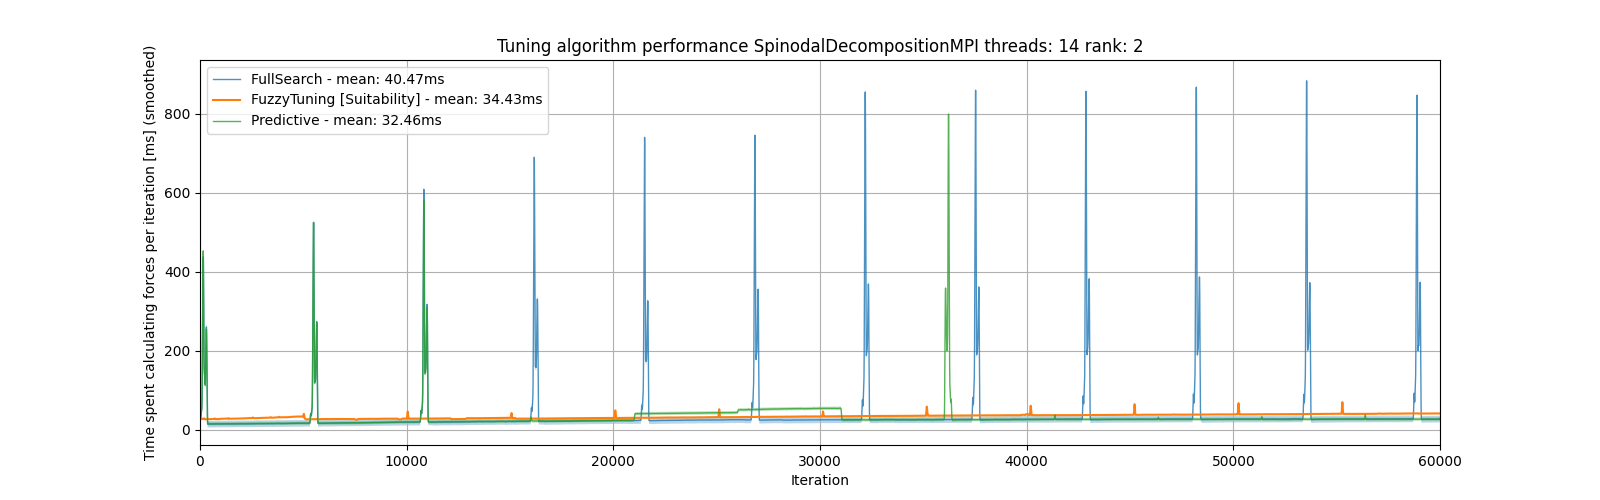

36.37741674656667
31.37580466195
31.000231436483332


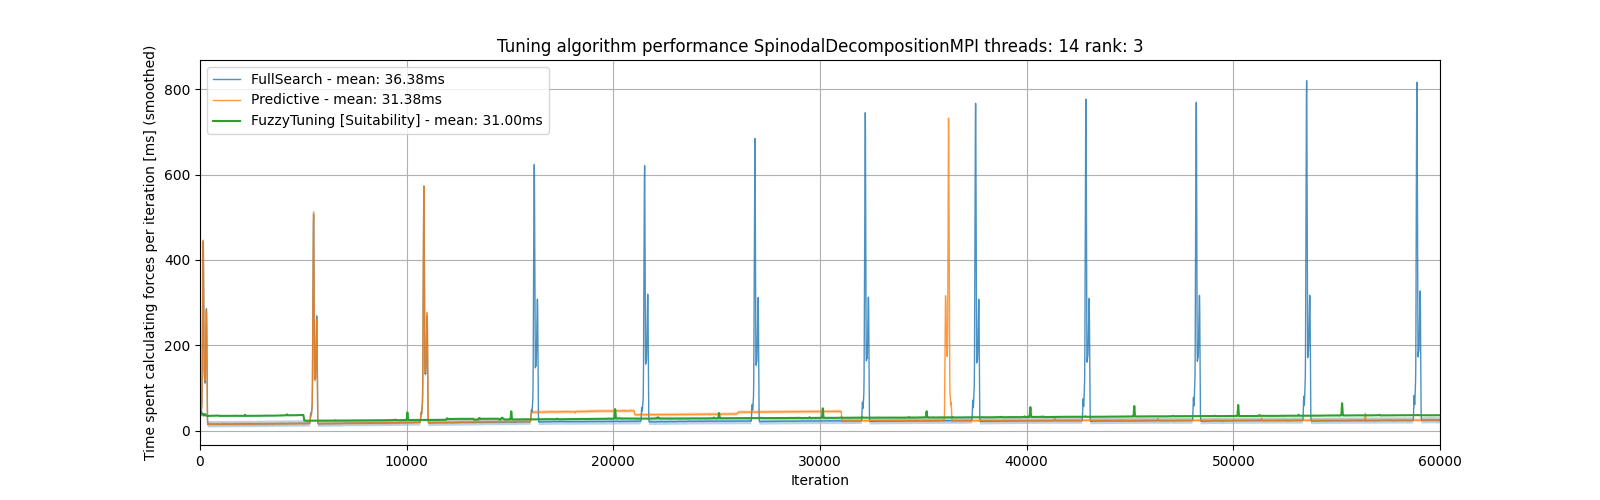

37.268211567073884
30.76831793163447
30.695195111114817


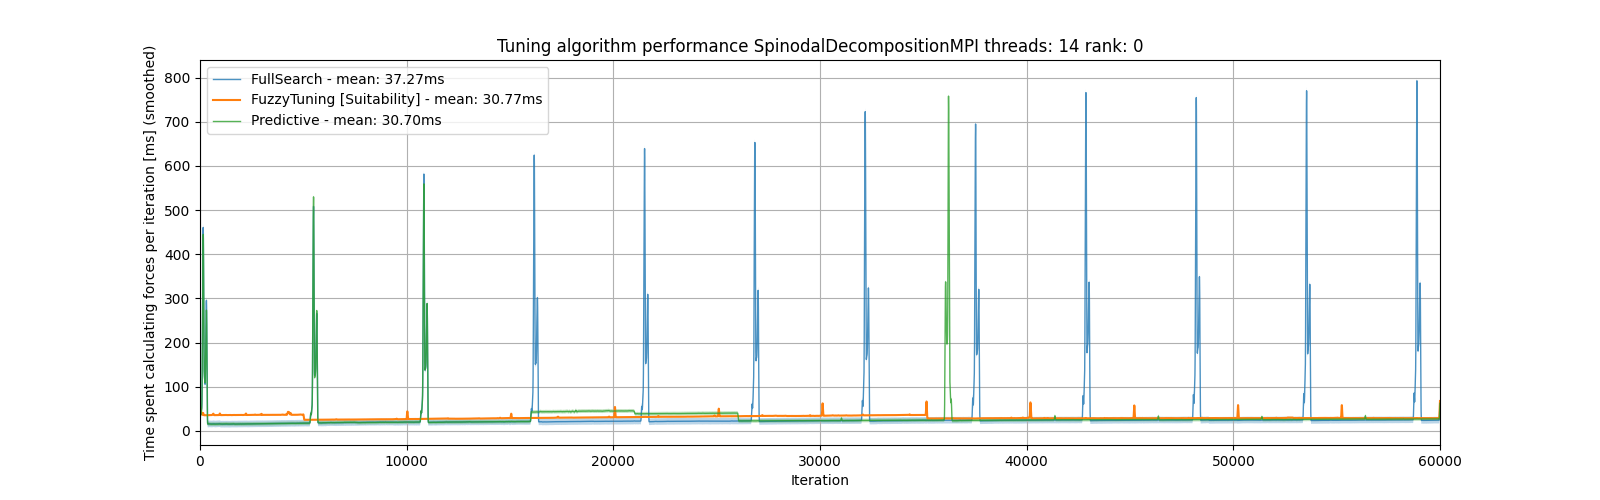

40.8839800597
34.88942404485
30.544390392249998


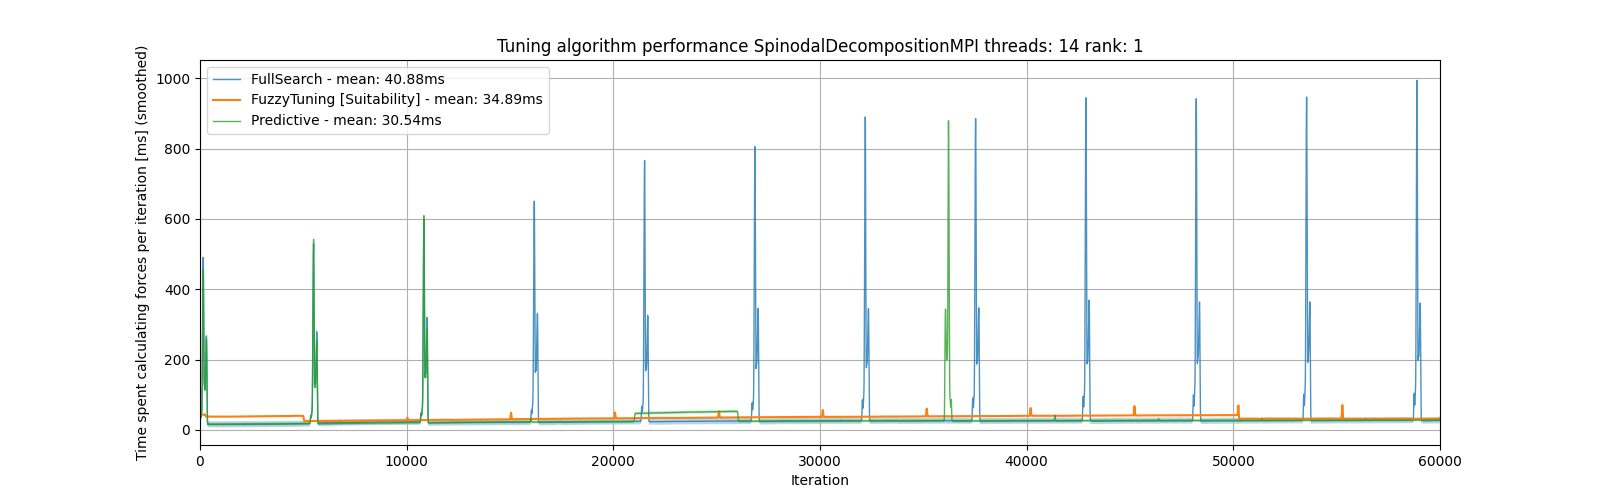

In [83]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, t_data in s_data.items():

        for rank, r_data in t_data.items():

            fig, ax = plt.subplots(1, 1, figsize=(16, 5))

            # sort by mean time spent calculating forces
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):

                iteration_data = logs["iterationPerformance"]

                time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

                first_k = 1000000

                x = iteration_data["Iteration"][:first_k]
                y = time_s[:first_k] * 1000

                mean = y.mean()

                print(mean)

                # ax.plot(x, y, label=f"{tuning_algorithm} - mean: {meanNS:.2f}ns")

                if np.logical_or(np.isnan(y), np.isinf(y)).any():
                    raise ValueError(f"Found NaN or Inf in {
                        tuning_algorithm + threads + scenario}")

                n = int(len(y)/20)

                smoother = ConvolutionSmoother(
                    window_len=80, window_type='blackman')
                smoother.smooth(y)

                low, up = smoother.get_intervals('sigma_interval', n_sigma=0.1)

                linewidth = 1.5 if "Fuzzy" in tuning_algorithm else 1
                opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8

                ax.plot(smoother.smooth_data[0], label=f"{
                        tuning_algorithm} - mean: {mean:.2f}ms", linewidth=linewidth, alpha=opacity)

                plt.fill_between(
                    range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

            ax.legend()
            ax.set_xlabel("Iteration")
            ax.set_ylabel(
                "Time spent calculating forces per iteration [ms] (smoothed)")

            # set y axis to mikro seconds

            ax.set_title(f"Tuning algorithm performance {
                         scenario} threads: {threads} rank: {rank}")
            ax.set_xlim(0, iteration_data["Iteration"].max()+1)
            # log
            ax.grid()
            plt.show()

            # logarithmic scale
            ax.set_yscale('log')

            fig.savefig(
                f"SpinodalDecompositionMPI_timings_{scenario}_{threads}_{rank}.png", dpi=300)

# Make bar plots about total time

60001


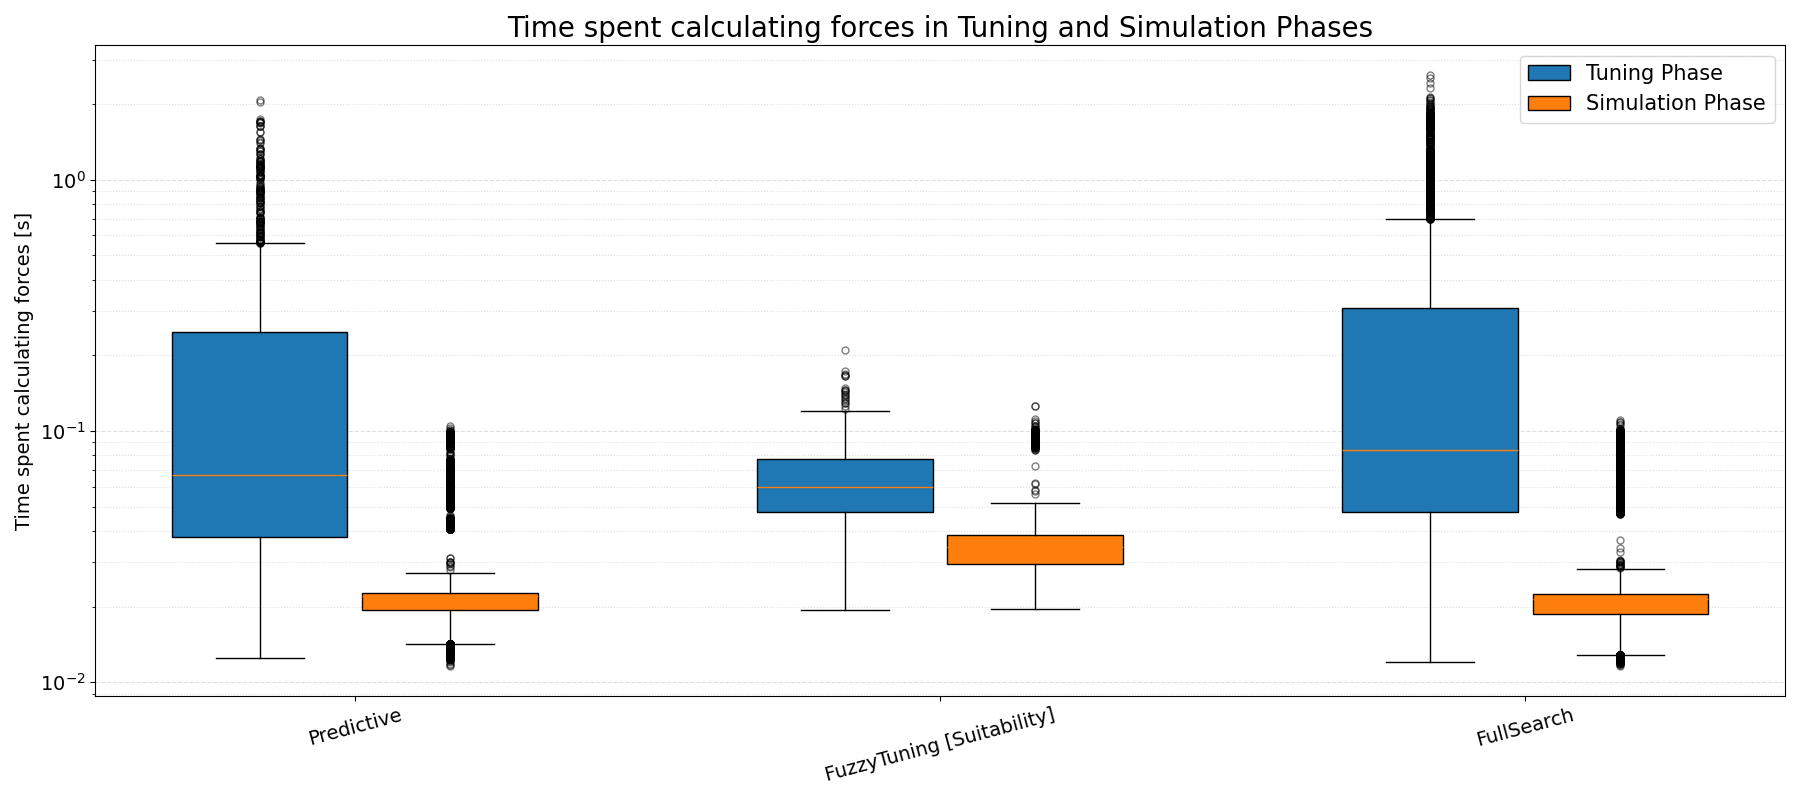

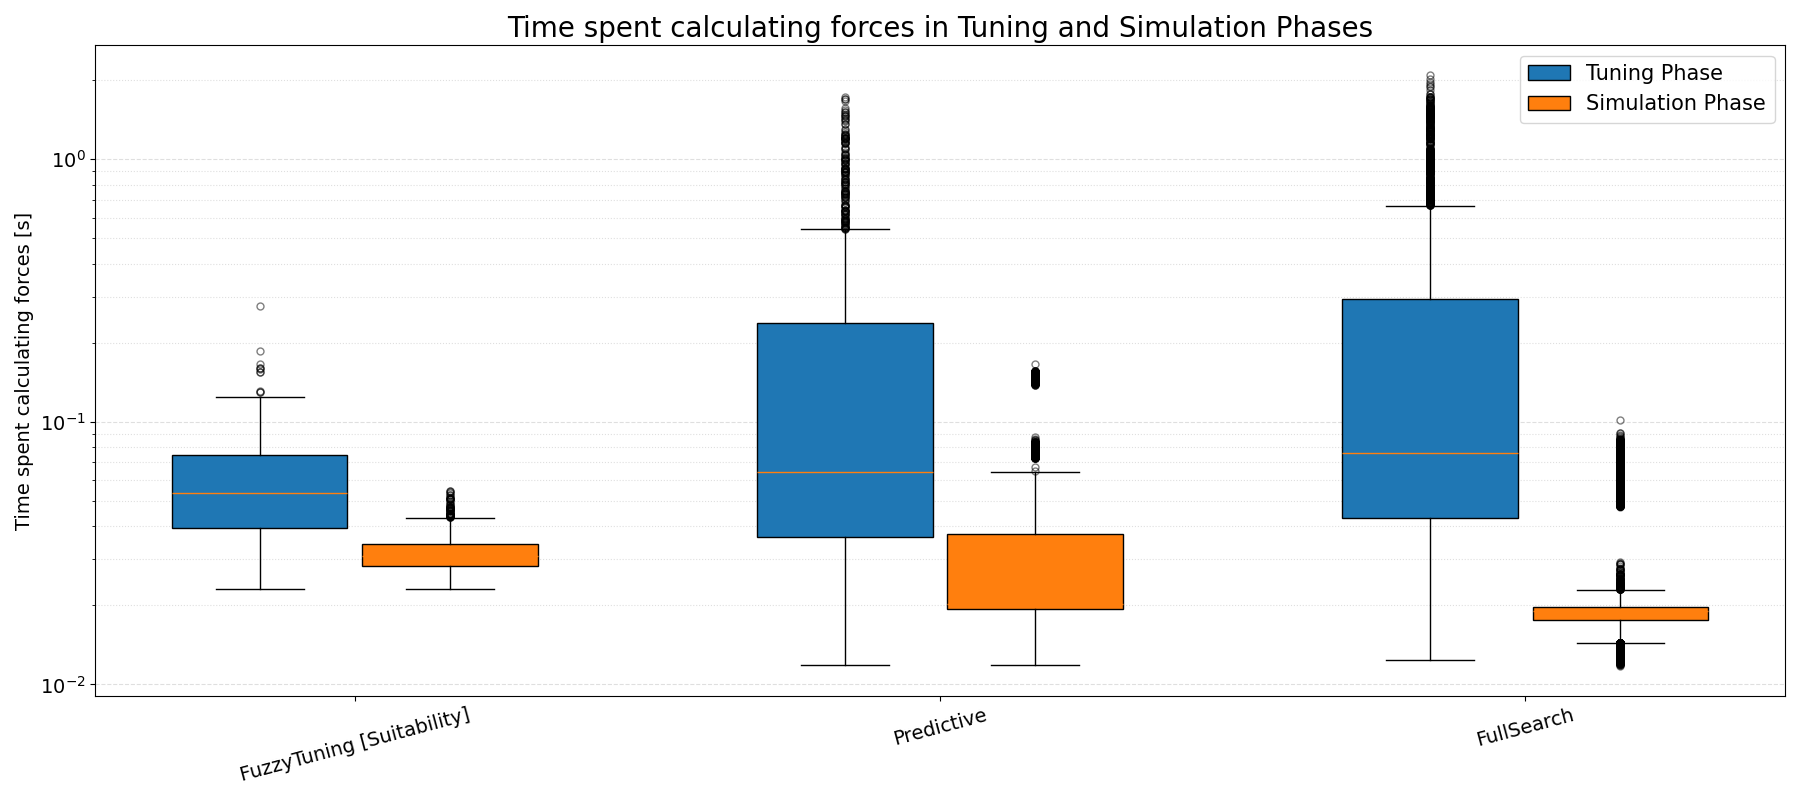

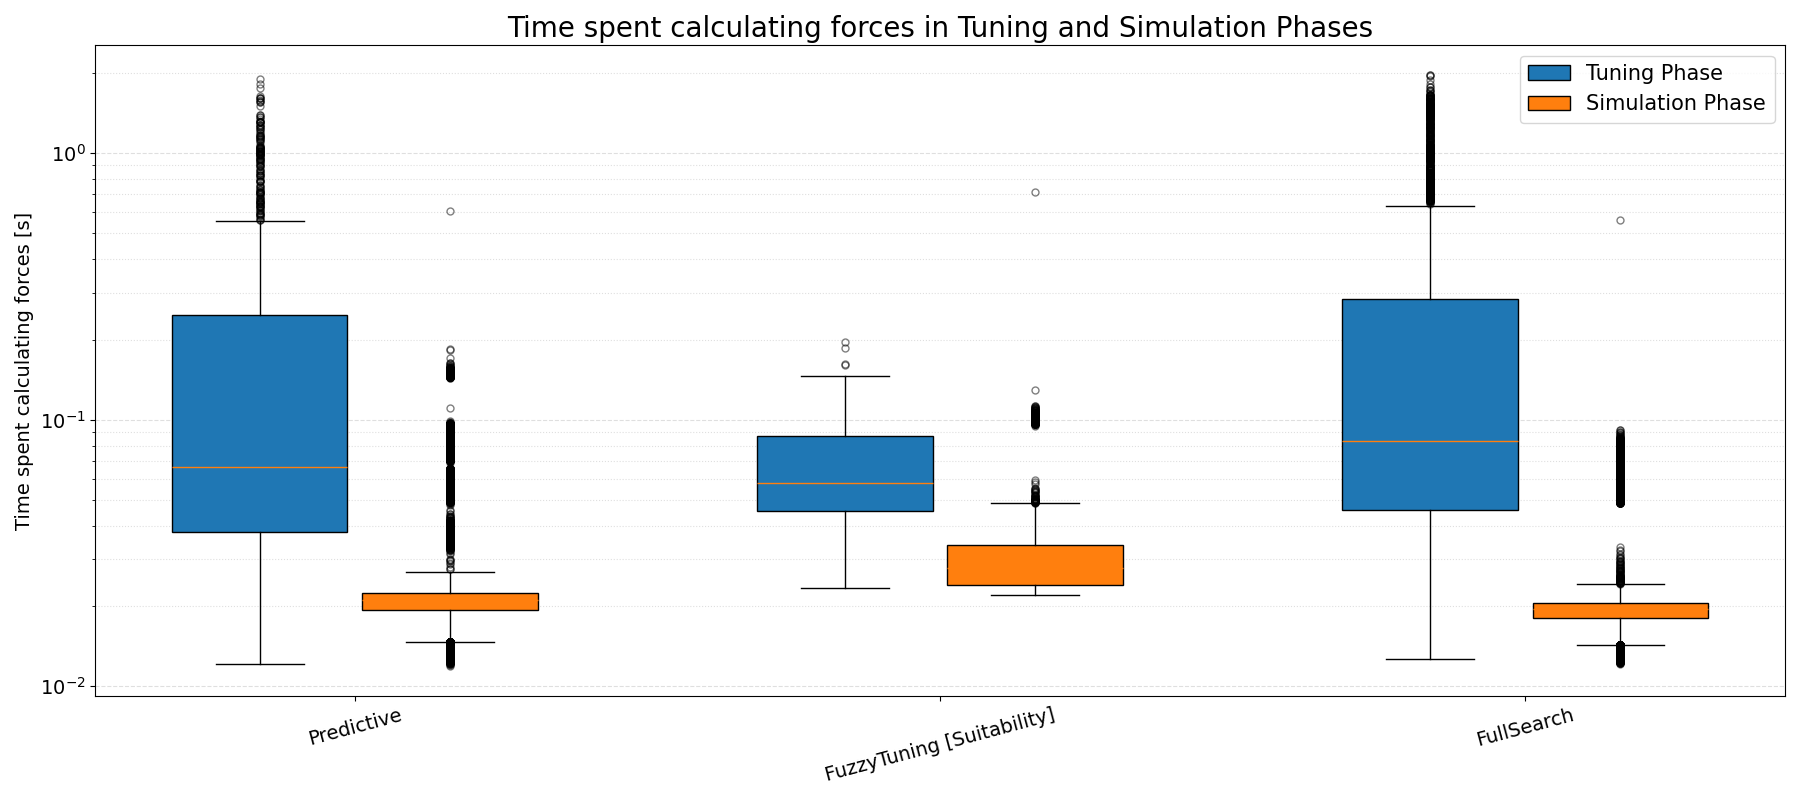

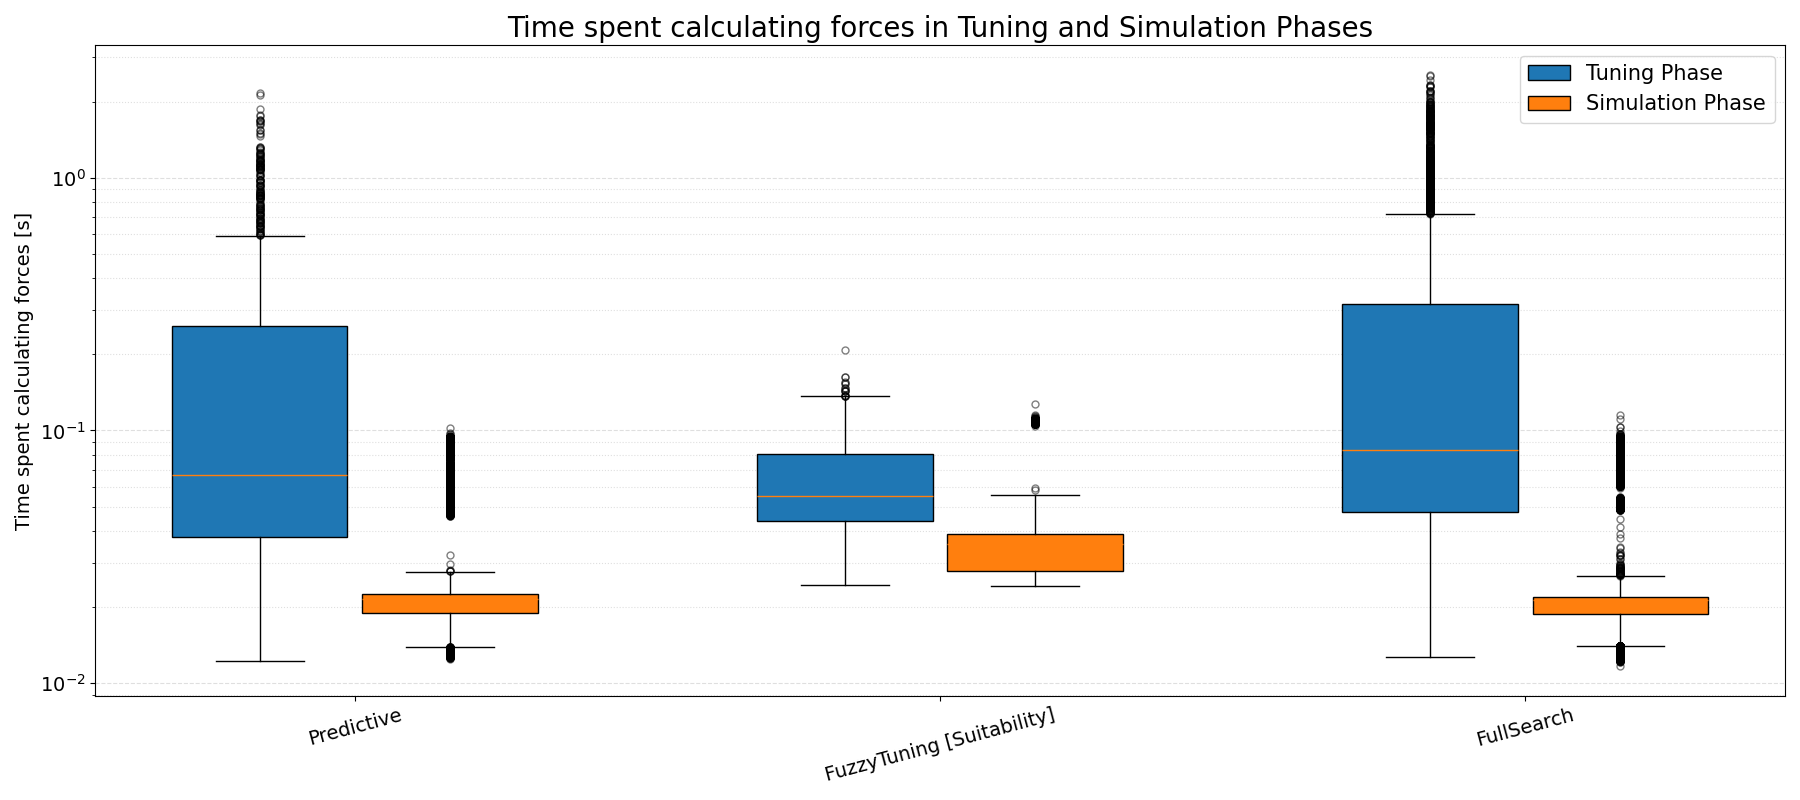

In [84]:
longest_simulation = 0
for scenario, s_data in data.items():

    for threads, t_data in s_data.items():

        for rank, r_data in t_data.items():

            # sort by mean time spent calculating forces
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

                longest_simulation = max(
                    longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)


for scenario, s_data in data.items():
    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):

        for rank, r_data in t_data.items():

            timings = {}
            algorithms = []

            # Collect data
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):
                algorithms.append(tuning_algorithm)
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                timings[tuning_algorithm] = {
                    "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"] / 1e9,
                    "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"] / 1e9
                }
            # Create plot
            fig, ax = plt.subplots(figsize=(18, 8))

            # Set positions for boxplots
            # Increased spacing between algorithm groups
            positions = range(0, len(algorithms) * 4, 4)
            width = 1.2  # Increased width of boxes

            # Function to add jittered points
            def add_jittered_points(data, pos, color, alpha=0.2):
                y = data
                x = np.random.normal(pos, 0.1, size=len(y))
                ax.scatter(x, y, alpha=alpha, s=10, color=color, zorder=3)
            # Create boxplots with jittered outliers
            bp_tuning = ax.boxplot([timings[alg]["Tuning Phases"] for alg in algorithms],
                                   positions=[p - width/2 -
                                              0.05 for p in positions],
                                   widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5))

            bp_simulation = ax.boxplot([timings[alg]["Simulation Phases"] for alg in algorithms],
                                       positions=[p + width/2 +
                                                  0.05 for p in positions],
                                       widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5))

            # Add scatter plots
            # for i, alg in enumerate(algorithms):
            #     add_jittered_points(
            #         timings[alg]["Tuning Phases"], positions[i] - width/2, '#3498db')
            #     add_jittered_points(
            #         timings[alg]["Simulation Phases"], positions[i] + width/2, '#e67e22')

            # Increase font sizes
            plt.title(
                'Time spent calculating forces in Tuning and Simulation Phases', fontsize=20)
            ax.set_ylabel('Time spent calculating forces [s]', fontsize=16)

            # Rotate x-axis labels
            plt.xticks(rotation=15, fontsize=14)
            plt.yticks(fontsize=14)

            # Use more distinct colors
            for box in bp_tuning['boxes']:
                box.set(facecolor='#1f77b4')
            for box in bp_simulation['boxes']:
                box.set(facecolor='#ff7f0e')  # Orange

            ax.set_xticks(positions)
            ax.set_xticklabels(algorithms, rotation=15)

            # minor grid lines on y
            ax.yaxis.grid(True, linestyle=':', which='minor',
                          color='grey', alpha=.25)

            # Add legend
            ax.legend([bp_tuning["boxes"][0], bp_simulation["boxes"][0]],
                      ["Tuning Phase", "Simulation Phase"], fontsize=15)

            # Logarithmic y-axis
            ax.set_yscale('log')

            # more grid lines
            ax.yaxis.grid(True, linestyle='--', which='major',
                          color='grey', alpha=.25)

            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)

            fig.tight_layout()

            fig.savefig(f"SpinodalDecompositionMPI_timings_boxplot_{
                        scenario}_{threads}_{rank}.png", dpi=300)

            plt.show()

60001


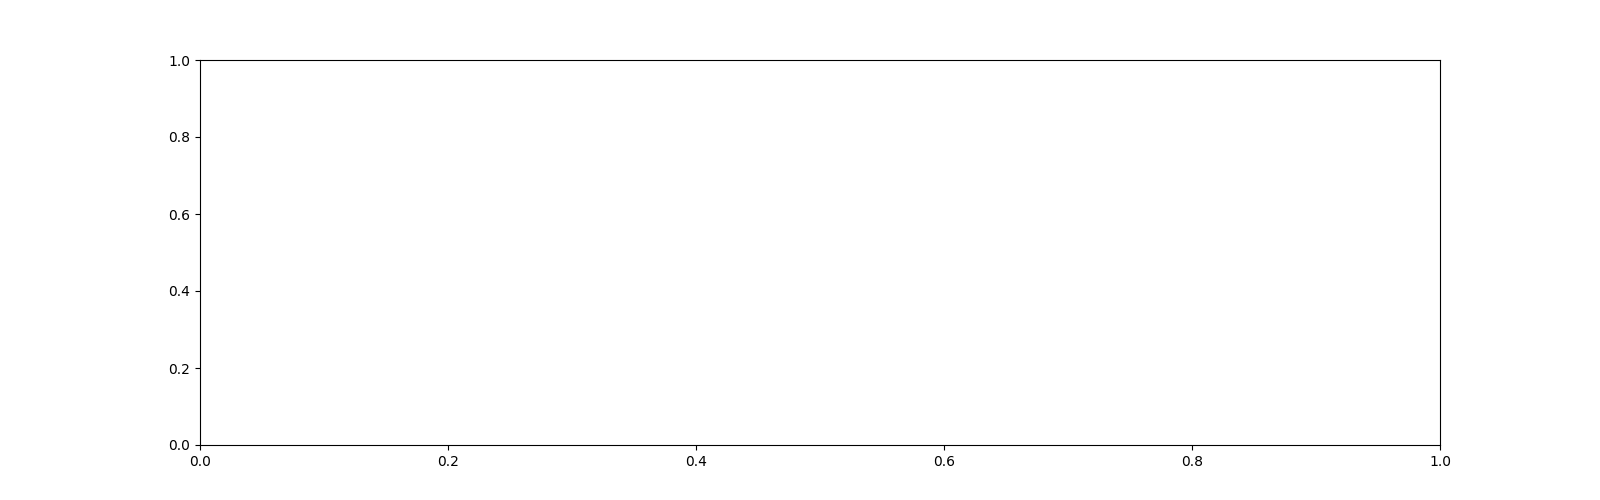

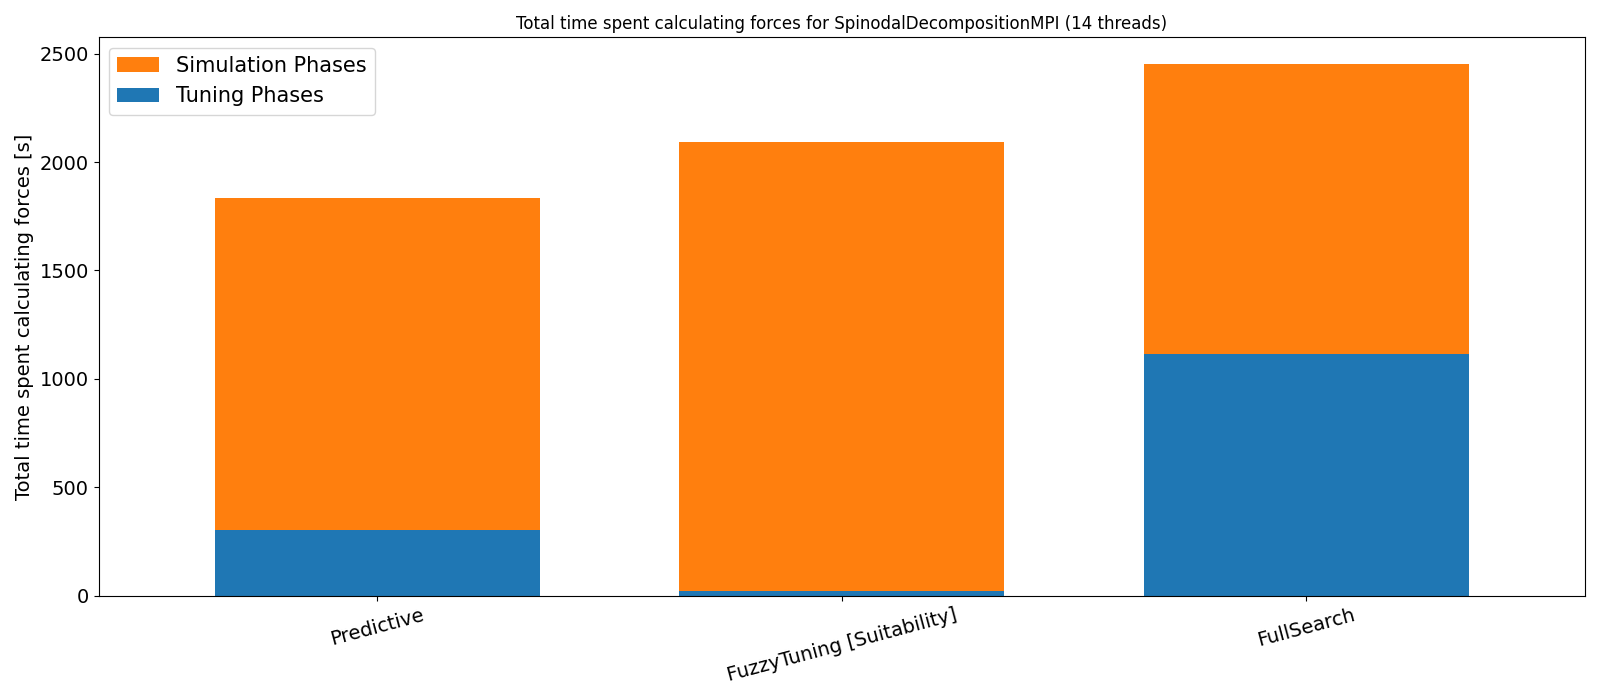

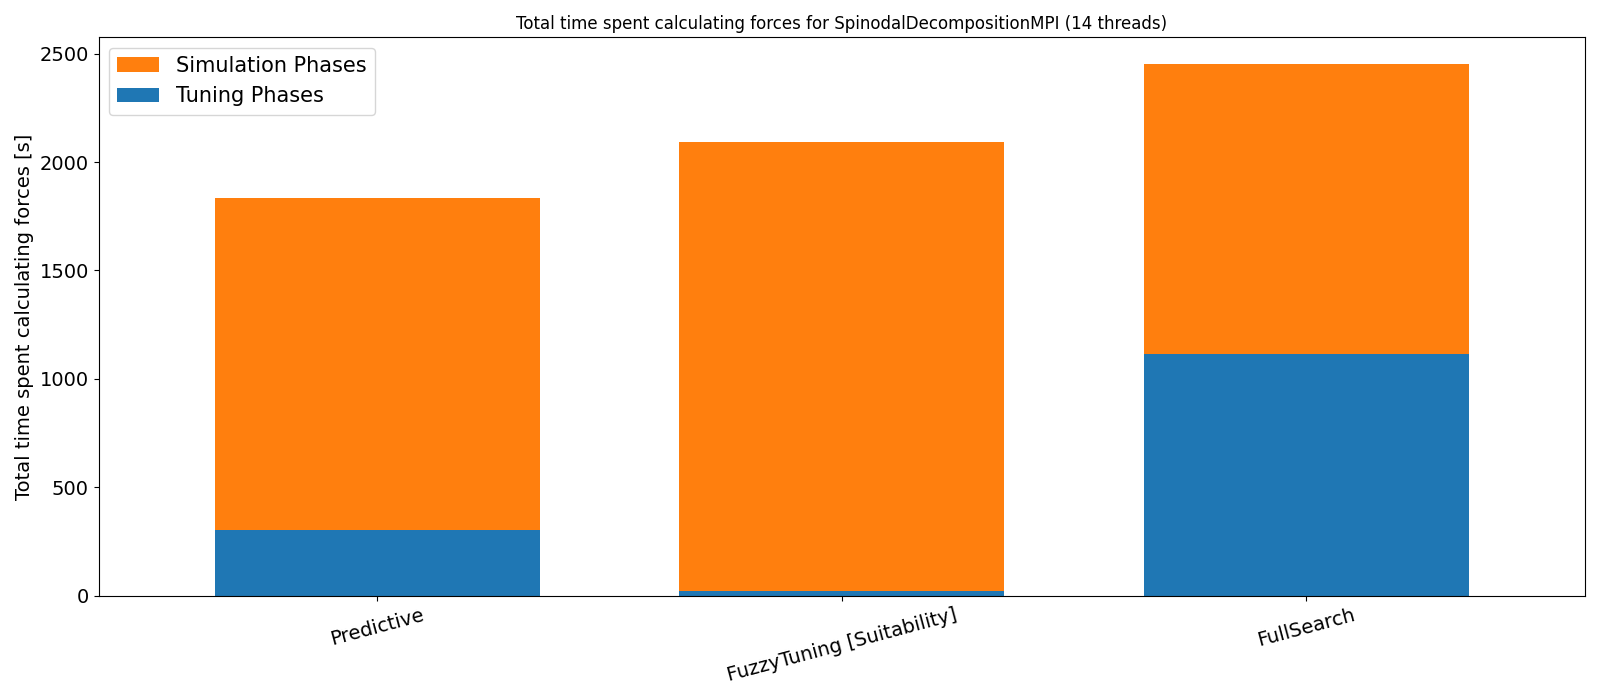

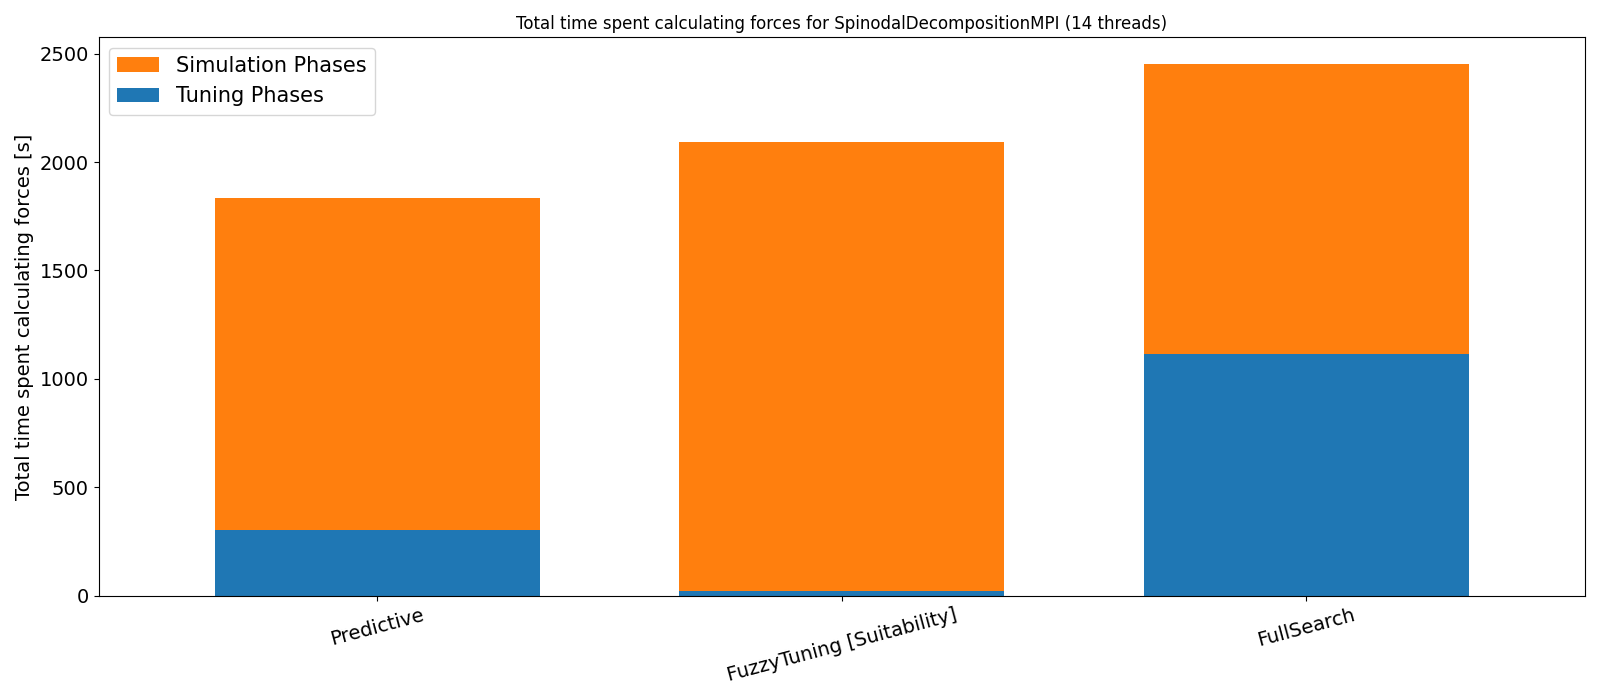

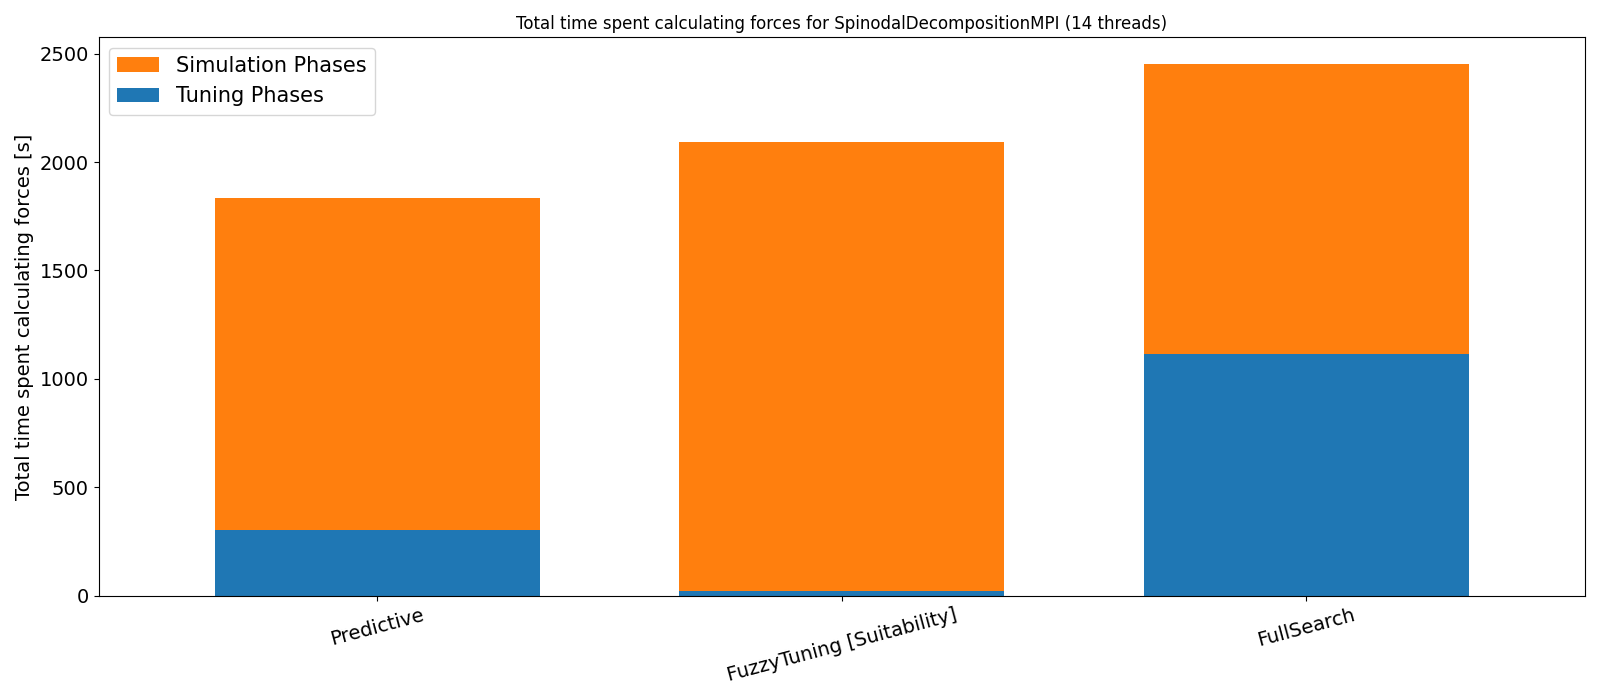

In [72]:
longest_simulation = 0
for scenario, s_data in data.items():

    for threads, t_data in s_data.items():

        for rank, r_data in t_data.items():

            # sort by mean time spent calculating forces
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

                longest_simulation = max(
                    longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)


for scenario, s_data in data.items():

    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        for rank, logs in t_data.items():

            # sort by mean time spent calculating forces
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):

                # filter logs only include where intuningphase is true
                iteration_data = logs["iterationPerformance"]

                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                tuning_time_s = tuning_iterations["iteratePairwiseTotal[ns]"].sum(
                ) / 1e9
                simulation_time_s = simulation_iterations["iteratePairwiseTotal[ns]"].sum(
                ) / 1e9

                timings[tuning_algorithm] = {
                    "Tuning Phases": tuning_time_s,
                    "Simulation Phases": simulation_time_s
                }

            # df with tuning algorithm as row
            df = pd.DataFrame(timings).T

            fig, ax = plt.subplots(1, 1, figsize=(16, 7))

            df.plot(kind='bar', stacked=True, ax=ax, width=0.7)

            # tilt x labels
            plt.xticks(rotation=15, fontsize=16)

            ax.set_ylabel(
                "Total time spent calculating forces [s]", fontsize=16)

            ax.set_title(f"Total time spent calculating forces for {
                scenario} ({threads} threads)")

            handles, lables = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], lables[::-1], prop={'size': 15})

            # make y axis bigger
            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)

            fig.tight_layout()

            # logarithmic scale

            fig.savefig(f"SpinodalDecompositionMPI_timings_total_{
                        scenario}_{threads}_{rank}.png", dpi=300)